# EDA

The purpose of this notebook is to explore data distribution and size

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank  #had to install via github
import librosa #had to pip install

In [4]:
df = pd.read_csv('FILE_PATH/wav_species.csv')
df.head()

In [6]:
df.set_index('wav', inplace=True)
df.head()

,bird_names
wav,
XC71196 - Great Horned Owl - Bubo virginianus.wav,Great Horned Owl
XC420904 - Northern Cardinal - Cardinalis cardinalis.wav,Northern Cardinal
XC125899 - Great-tailed Grackle - Quiscalus mexicanus.wav,Great-tailed Grackle
XC370940 - Carolina Wren - Thryothorus ludovicianus.wav,Carolina Wren
XC277224 - Carolina Wren - Thryothorus ludovicianus.wav,Carolina Wren


In [8]:
for i in df.index:
    rate, signal = wavfile.read(f'FILE_PATH/wav_downloads/{i}')
#     print(signal.shape[0])
    df.at[i, 'length'] = signal.shape[0]/rate

df.head()

,bird_names,length
wav,,
XC71196 - Great Horned Owl - Bubo virginianus.wav,Great Horned Owl,89.496000
XC420904 - Northern Cardinal - Cardinalis cardinalis.wav,Northern Cardinal,40.056000
XC125899 - Great-tailed Grackle - Quiscalus mexicanus.wav,Great-tailed Grackle,5.459592
XC370940 - Carolina Wren - Thryothorus ludovicianus.wav,Carolina Wren,172.968000
XC277224 - Carolina Wren - Thryothorus ludovicianus.wav,Carolina Wren,16.274286


In [9]:
df.groupby(['bird_names'])['length'].describe().head()

,count,mean,std,min,25%,50%,75%,max
bird_names,,,,,,,,
Black-bellied Whistling Duck,120.0,27.374397,32.350380,1.872000,9.653895,18.337959,26.301513,200.655238
Blue Jay,271.0,40.571438,41.992953,0.899819,13.387755,27.248396,53.965791,285.064036
Carolina Wren,401.0,48.584434,65.912405,1.488980,17.057959,31.451429,56.594467,557.574150
Great Horned Owl,232.0,68.253562,70.606664,2.664000,16.202449,49.613855,95.118367,517.537959
Great-tailed Grackle,165.0,57.310401,82.032923,0.846485,10.711383,25.338776,68.544000,604.735937


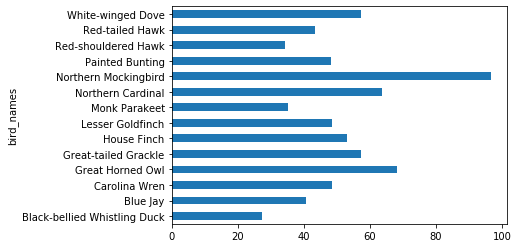

In [10]:
df.groupby(['bird_names'])['length'].mean().plot(kind='barh');

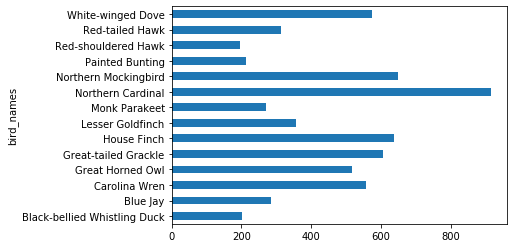

In [11]:
df.groupby(['bird_names'])['length'].max().plot(kind='barh');

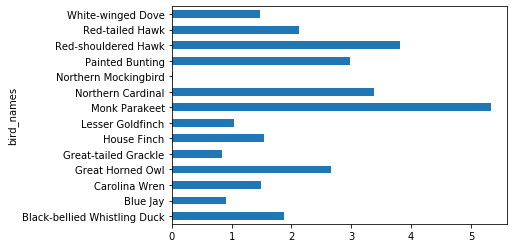

In [12]:
df.groupby(['bird_names'])['length'].min().plot(kind='barh');

In [46]:
classes = list(np.unique(df.bird_names))
signals = {}
fft = {}
fbank = {}
mfccs = {}

def plot_signals(signals):
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(12,3))
    fig.suptitle('Time Series', size=16, y=1.12)
    for ax, i in zip(axs.ravel(), range(6)):
        ax.set_title(list(signals.keys())[i])
        ax.plot(list(signals.values())[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.tight_layout()

def plot_fft(fft):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,3))
    fig.suptitle('Fourier Transforms', size=16, y=1.12)
    for ax, i in zip(axs.ravel(), range(6)):
        data = list(fft.values())[i]
        Y, freq = data[0], data[1]
        ax.set_title(list(fft.keys())[i])
        ax.plot(freq, Y)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.tight_layout()

def plot_fbank(fbank):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,3))
    fig.suptitle('Filter Bank Coefficients', size=16, y=1.12)
    for ax, i in zip(axs.ravel(), range(6)):
        ax.set_title(list(fbank.keys())[i])
        ax.imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.tight_layout()

def plot_mfccs(mfccs):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,3))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16, y=1.12)
    for ax, i in zip(axs.ravel(), range(6)):
        ax.set_title(list(mfccs.keys())[i])
        ax.imshow(list(mfccs.values())[i],
                cmap='hot', interpolation='nearest')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.tight_layout()

def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

# noise floor detection of a signal
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1,
                       center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

for c in classes[6:]:
    wav_file = df[df.bird_names == c].index[0]
    signal, rate = librosa.load('FILE_PATH/wav_downloads/'+wav_file, sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

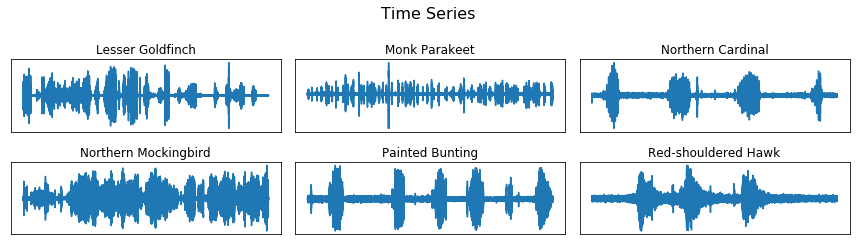

In [40]:
plot_signals(signals)

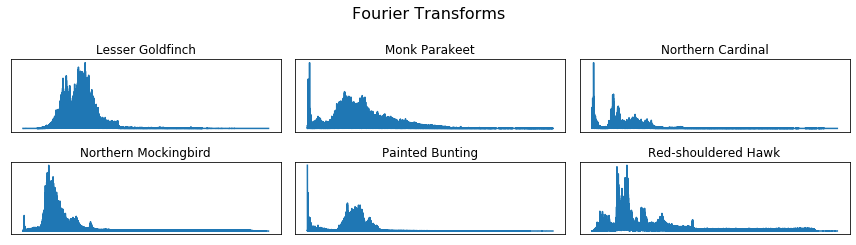

In [41]:
plot_fft(fft)

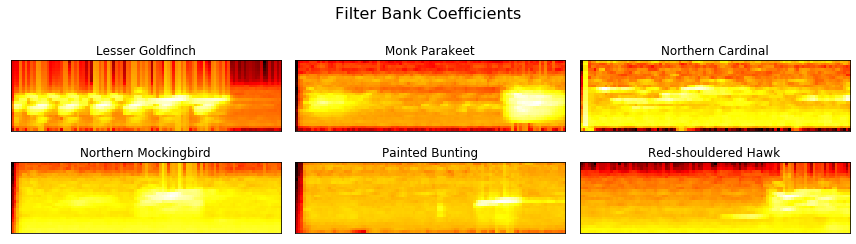

In [42]:
plot_fbank(fbank)

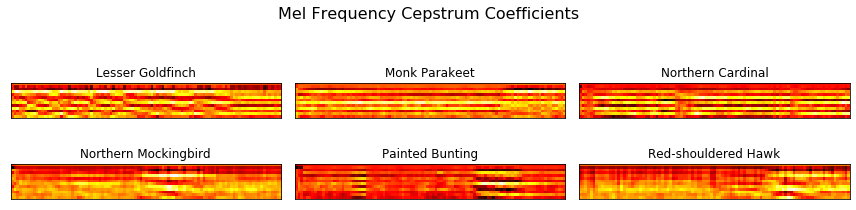

In [43]:
plot_mfccs(mfccs)

## Clean and Export

In [ ]:
# this code takes a lot of time and processing power
for f in tqdm(df.index):
    signal, rate = librosa.load('wav_downloads/' +f, sr=16000)
    mask = envelope(signal, rate, 0.0005)
    wavfile.write(filename='clean/'+f, rate=rate, data=signal[mask])